# Linear mixed model

In [46]:
# generate data

import numpy as np

np.random.seed(1)
n, m = 10, 10
mu, sigma, kappa = 3, 0.1, 0.1

theta = np.random.normal(mu, sigma, n)
x = np.random.normal(theta, kappa, (m, n))

In [47]:
# define a statistical model

import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

numpyro.set_host_device_count(4) # 4スレッドで並列計算

def model(x):
   mu = numpyro.sample('mu', dist.Uniform(low=-100, high=100))
   sigma = numpyro.sample('sigma', dist.Uniform(low=0, high=100))
   kappa = numpyro.sample('kappa', dist.Uniform(low=0, high=100))
   with numpyro.plate('n', x.shape[1]):
      theta = numpyro.sample('theta', dist.Normal(mu, sigma))
      with numpyro.plate('m', x.shape[0]):
         numpyro.sample('x', dist.Normal(theta, kappa), obs=x)

   # for j in range(x.shape[1]):
   #    theta = numpyro.sample(f'theta_{j}', dist.Normal(mu, sigma))
   #    for i in range(x.shape[0]):
   #       numpyro.sample(f'x_{i}_{j}', dist.Normal(theta, kappa), obs=x[i,j])

In [48]:
# run MCMC

from jax import random
from numpyro.infer import MCMC, NUTS

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

num_warmup, num_samples, num_chains = 1000, 2000, 4

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
mcmc.run(rng_key_, x=x)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [49]:
# check the posterior distribution

mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     kappa      0.08      0.01      0.08      0.07      0.10   8736.54      1.00
        mu      3.00      0.05      3.00      2.91      3.08   8781.27      1.00
     sigma      0.15      0.05      0.14      0.09      0.22   5518.31      1.00
  theta[0]      3.14      0.03      3.14      3.10      3.18  11600.99      1.00
  theta[1]      2.94      0.03      2.94      2.89      2.98  12342.65      1.00
  theta[2]      2.94      0.03      2.94      2.90      2.98  10559.41      1.00
  theta[3]      2.91      0.03      2.91      2.87      2.96  12064.14      1.00
  theta[4]      3.10      0.03      3.10      3.05      3.14  10750.08      1.00
  theta[5]      2.74      0.03      2.74      2.70      2.79   9310.93      1.00
  theta[6]      3.17      0.03      3.17      3.13      3.21  10008.85      1.00
  theta[7]      2.96      0.03      2.96      2.91      3.00  12510.69      1.00
  theta[8]      3.06      0

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'kappa'}>,
        <Axes: title={'center': 'kappa'}>]], dtype=object)

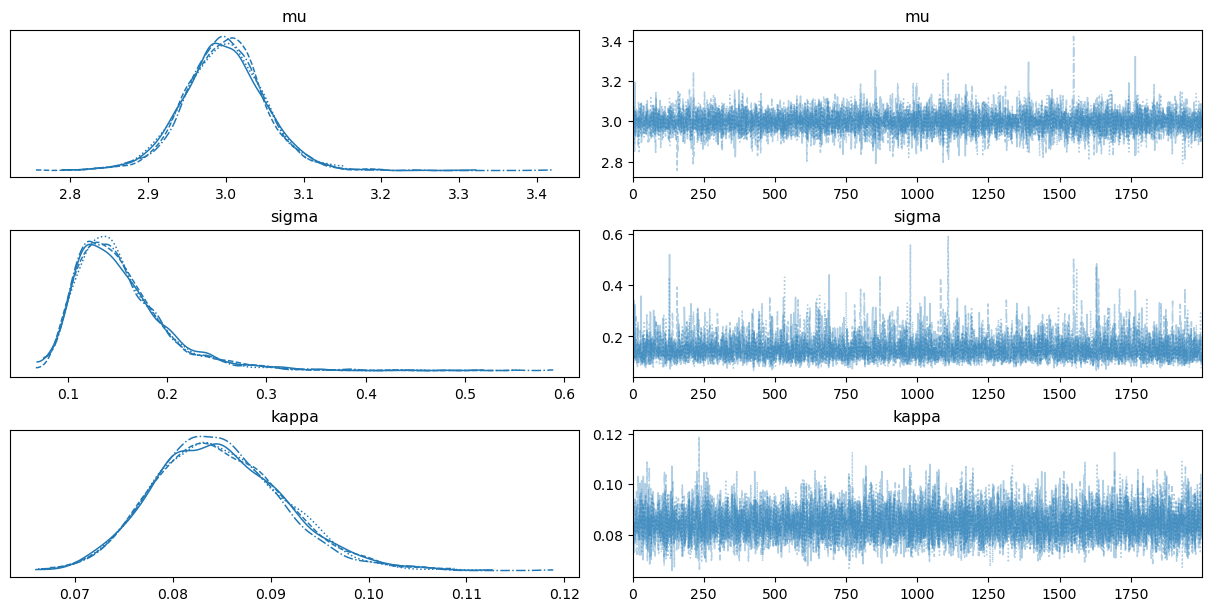

In [50]:
import arviz

arviz.plot_trace(mcmc, var_names=['mu', 'sigma', 'kappa'], backend_kwargs={'constrained_layout': True})

In [51]:
# visualize the predictive distribution

from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

rng_key, rng_key_ = random.split(rng_key)

pred = Predictive(model, mcmc.get_samples(), return_sites=["y"])
x_ = jnp.linspace(-3, 3, 1000)
predictions = pred(rng_key, x=x_, y=None)

mean_y = jnp.mean(predictions['y'], axis=0)
hpdi_y = hpdi(predictions['y'], 0.95)

plt.fill_between(x_, hpdi_y[0], hpdi_y[1], alpha=0.3, color='tab:blue')
plt.plot(x_, mean_y, lw=2, color='tab:red')
plt.plot(x, y, '+', markersize=12, color='tab:blue')
plt.xlabel('$x$', size=28)
plt.ylabel('$y$', size=28)
plt.tight_layout()

TypeError: model() got an unexpected keyword argument 'y'